In [4]:
import geemap
import ee

In [5]:
ee.Initialize()

In [9]:

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
from rasterio.features import rasterize
from io import BytesIO
from owslib.wfs import WebFeatureService

import rioxarray
import contextily as ctx
from shapely.geometry import box
import xarray as xr


USE_CRS = "EPSG:5347"  # posgar para esperanza
WEB_MERCATOR_CRS = "EPSG:3857"

DEFAULT_FIGSIZE = (12, 10)
MAP_PADDING = 500
PLASMA_CMAP = plt.cm.plasma

def setup_base_map(
    figsize=None, bounds=None, boundary_gdf=None, padding_x=None, padding_y=None
):
    """Create figure and set up basic map boundaries with padding."""
    if figsize is None:
        figsize = DEFAULT_FIGSIZE
    if padding_x is None:
        padding_x = MAP_PADDING
    if padding_y is None:
        padding_y = MAP_PADDING

    if bounds is None and boundary_gdf is not None:
        bounds = boundary_gdf.total_bounds

    # Convert bounds to Web Mercator for basemap compatibility
    if bounds is not None:
        # Create a temporary GeoDataFrame with the bounds to reproject
        temp_bounds = gpd.GeoDataFrame(
            geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])], crs=USE_CRS
        )
        bounds_3857 = temp_bounds.to_crs(WEB_MERCATOR_CRS).total_bounds
    else:
        bounds_3857 = bounds

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds_3857[0] - padding_x, bounds_3857[2] + padding_x)
    ax.set_ylim(bounds_3857[1] - padding_y, bounds_3857[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""

    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )

    return ax


def add_north_arrow(ax, x=0.95, y=0.05, arrow_length=0.04):
    """Add a north arrow to the map."""
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="black", width=3, headwidth=10),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=ax.transAxes,
    )


def add_boundary_outline(ax, boundary_gdf, crs="EPSG:3857"):
    """Add the outline of a boundary geodataframe to a map."""
    boundary_3857 = boundary_gdf.to_crs(crs)
    boundary_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        linewidth=0.5,
        linestyle="--",
        legend=False,
        zorder=5,
    )


def create_consistent_map(title, boundary_gdf, bounds=None):
    """Create a map with consistent styling and basemap."""
    fig, ax = setup_base_map(bounds=bounds, boundary_gdf=boundary_gdf)

    add_basemap(ax)

    add_north_arrow(ax)

    add_boundary_outline(ax, boundary_gdf)

    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)

    ax.set_axis_off()

    return fig, ax


def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

dptos = wfs_to_gdf(wfs_url=base_url, layer_name="ign:departamento", srs="EPSG:4326")

aoi = dptos[dptos["nam"] == "Río Segundo"]
aoi = aoi.to_crs(USE_CRS)

In [10]:
# Create lists of all available years
modis_years = list(range(2000, 2021))  # 2000-2020
viirs_years = list(range(2012, 2022))  # 2012-2021

# Function to create FeatureCollection for a specific year and dataset
def create_fire_collection(dataset, year):
    """Create a FeatureCollection for a specific dataset and year"""
    if dataset == 'modis':
        path = f"projects/sat-io/open-datasets/MODIS_MCD14DL/MCD14DL_{year}"
    elif dataset == 'viirs':
        path = f"projects/sat-io/open-datasets/VIIRS/VNP14IMGTDL_NRT_{year}"
    else:
        raise ValueError("Dataset must be 'modis' or 'viirs'")
    
    try:
        return ee.FeatureCollection(path)
    except Exception as e:
        print(f"Warning: Could not load {dataset} data for year {year}: {e}")
        return None

# Load all MODIS data (2000-2020)
print("Loading MODIS data (2000-2020)...")
modis_collections = []
for year in modis_years:
    collection = create_fire_collection('modis', year)
    if collection is not None:
        modis_collections.append(collection)

# Load all VIIRS data (2012-2021)
print("Loading VIIRS data (2012-2021)...")
viirs_collections = []
for year in viirs_years:
    collection = create_fire_collection('viirs', year)
    if collection is not None:
        viirs_collections.append(collection)

# Combine all collections into single FeatureCollections
print("Combining all years...")
all_modis = ee.FeatureCollection(modis_collections).flatten()
all_viirs = ee.FeatureCollection(viirs_collections).flatten()

# Filter by area of interest
ee_aoi = geemap.geopandas_to_ee(aoi)

print("Filtering by area of interest...")
all_modis_aoi = all_modis.filterBounds(ee_aoi)
all_viirs_aoi = all_viirs.filterBounds(ee_aoi)

Loading MODIS data (2000-2020)...
Loading VIIRS data (2012-2021)...
Combining all years...
Filtering by area of interest...


In [12]:
# Get a color from a day or night
class_color = ee.Dictionary({
    'D': '0565A6',
    'N': '229A00'
})

classes = ['D', 'N']

def add_style(pt):
    """Add styling properties to each point based on brightness and day/night"""
    size = ee.Number(pt.get('bright_ti4')).divide(100)
    color = class_color.get(pt.get('daynight'))
    return pt.set('styleProperty', ee.Dictionary({'pointSize': size, 'color': color}))

# Style both MODIS and VIIRS data
modis_styled = all_modis_aoi.map(add_style)
viirs_styled = all_viirs_aoi.map(add_style)

# Create day and night fire layers for MODIS
modis_daytime = modis_styled.filter(ee.Filter.eq('daynight', 'D')).style(
    styleProperty='styleProperty',
    neighborhood=50
)

modis_nighttime = modis_styled.filter(ee.Filter.eq('daynight', 'N')).style(
    styleProperty='styleProperty', 
    neighborhood=50
)

# Create day and night fire layers for VIIRS
viirs_daytime = viirs_styled.filter(ee.Filter.eq('daynight', 'D')).style(
    styleProperty='styleProperty',
    neighborhood=50
)

viirs_nighttime = viirs_styled.filter(ee.Filter.eq('daynight', 'N')).style(
    styleProperty='styleProperty', 
    neighborhood=50
)

# Create the map
m = geemap.Map()

# Add all fire layers
m.addLayer(modis_daytime, {}, 'MODIS Daytime Fires', True, 0.65)
m.addLayer(modis_nighttime, {}, 'MODIS Nighttime Fires', True, 0.65)
m.addLayer(viirs_daytime, {}, 'VIIRS Daytime Fires', True, 0.65)
m.addLayer(viirs_nighttime, {}, 'VIIRS Nighttime Fires', True, 0.65)

m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [13]:
print(f"Total MODIS fires in AOI: {all_modis_aoi.size().getInfo()}")
print(f"Total VIIRS fires in AOI: {all_viirs_aoi.size().getInfo()}")

Total MODIS fires in AOI: 486
Total VIIRS fires in AOI: 561


In [17]:
# Convert styled layers back to feature collections
modis_day_fc = modis_styled.filter(ee.Filter.eq('daynight', 'D'))
modis_night_fc = modis_styled.filter(ee.Filter.eq('daynight', 'N'))
viirs_day_fc = viirs_styled.filter(ee.Filter.eq('daynight', 'D'))
viirs_night_fc = viirs_styled.filter(ee.Filter.eq('daynight', 'N'))

# Optional: Add styling properties as attributes for export
def add_export_properties(fc):
    """Add styling properties as regular attributes for easier export"""
    def add_props(feature):
        style_props = feature.get('styleProperty')
        return feature.set({
            'pointSize': ee.Dictionary(style_props).get('pointSize'),
            'color': ee.Dictionary(style_props).get('color')
        })
    return fc.map(add_props)

# Apply to all collections
modis_day_fc = add_export_properties(modis_day_fc)
modis_night_fc = add_export_properties(modis_night_fc)
viirs_day_fc = add_export_properties(viirs_day_fc)
viirs_night_fc = add_export_properties(viirs_night_fc)

In [19]:
modis_day_fc

In [21]:
# Convert to geodataframes directly from the original feature collections
modis_day_gdf = geemap.ee_to_gdf(all_modis_aoi.filter(ee.Filter.eq('daynight', 'D')))
modis_night_gdf = geemap.ee_to_gdf(all_modis_aoi.filter(ee.Filter.eq('daynight', 'N')))
viirs_day_gdf = geemap.ee_to_gdf(all_viirs_aoi.filter(ee.Filter.eq('daynight', 'D')))
viirs_night_gdf = geemap.ee_to_gdf(all_viirs_aoi.filter(ee.Filter.eq('daynight', 'N')))

In [23]:
modis_gdf=geemap.ee_to_gdf(all_modis_aoi)
viirs_gdf=geemap.ee_to_gdf(all_viirs_aoi)

In [24]:
print(modis_gdf.head())

                    geometry    acq_date  acq_time  bright_t31  brightness  \
0   POINT (-62.9187 -32.019)  2000-11-14      1439  295.600006  308.200012   
1  POINT (-63.6187 -31.5323)  2001-07-28      1433  273.799988  307.299988   
2  POINT (-63.6081 -31.5338)  2001-07-28      1433  277.100006  303.100006   
3  POINT (-63.6317 -31.5596)  2002-07-12      1811  296.100006  307.200012   
4  POINT (-63.6423 -31.5612)  2002-07-12      1811  299.700012  366.799988   

   confidence daynight         frp instrument satellite  scan  track  type  \
0          49        D    4.800000      MODIS     Terra   1.0    1.0     0   
1          49        D   10.400000      MODIS     Terra   1.0    1.0     0   
2          55        D    7.800000      MODIS     Terra   1.0    1.0     0   
3          32        D    4.200000      MODIS      Aqua   1.0    1.0     0   
4         100        D  104.300003      MODIS      Aqua   1.0    1.0     0   

   version  
0      6.2  
1      6.2  
2      6.2  
3      6.2

In [27]:
print(viirs_gdf.head())

                      geometry    acq_date  acq_time  bright_ti4  bright_ti5  \
0  POINT (-63.36078 -31.46117)  2012-10-24      1847  367.000000  293.230011   
1  POINT (-63.84928 -31.62288)  2012-07-25      1854  367.000000  293.890015   
2  POINT (-63.83323 -31.66405)  2012-06-27       515  301.040009  283.869995   
3  POINT (-63.83244 -31.66419)  2012-05-10       516  300.690002  286.739990   
4  POINT (-63.83203 -31.66506)  2012-07-18       522  297.760010  277.149994   

  confidence daynight    frp instrument satellite  scan  track  type  version  
0          h        D  20.32      VIIRS         N  0.45   0.63     0        1  
1          h        D  28.65      VIIRS         N  0.52   0.67     0        1  
2          n        N   0.61      VIIRS         N  0.38   0.36     0        1  
3          n        N   0.61      VIIRS         N  0.38   0.36     0        1  
4          n        N   0.83      VIIRS         N  0.39   0.36     0        1  


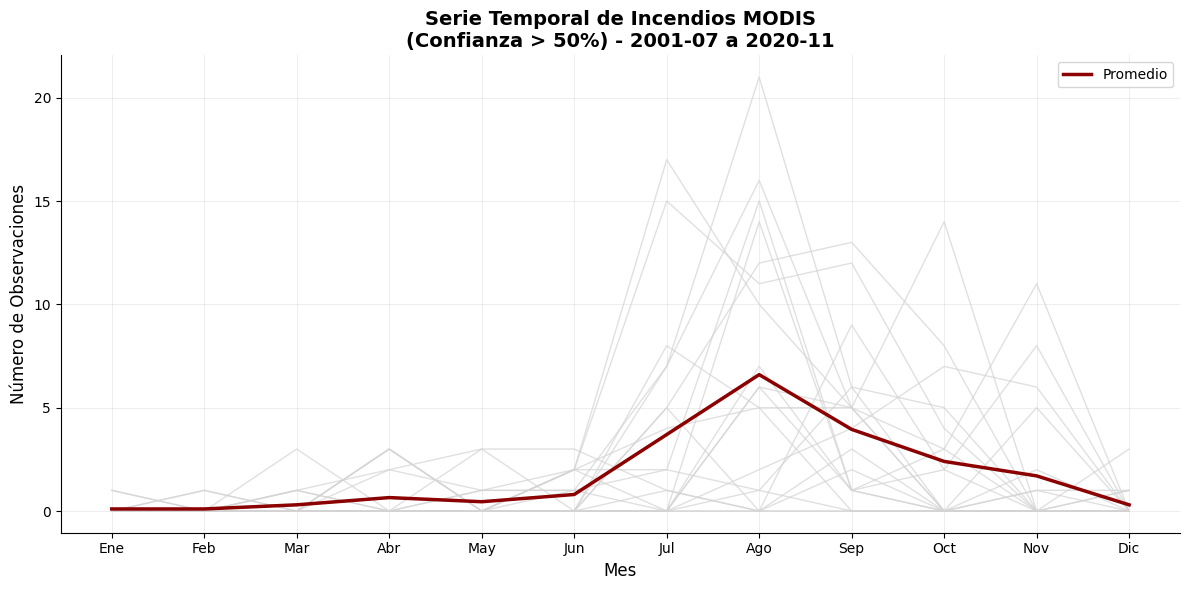

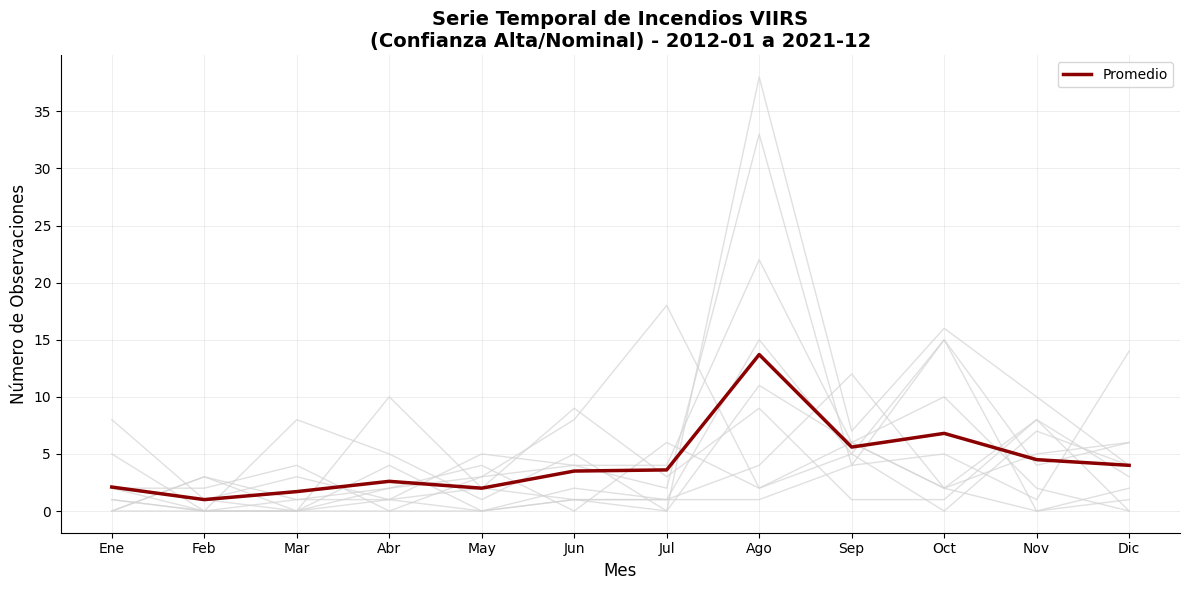

In [30]:
# MODIS - Filter for confidence > 50
modis_filtered = modis_gdf[modis_gdf['confidence'] > 50].copy()
modis_filtered['acq_date'] = pd.to_datetime(modis_filtered['acq_date'])
modis_filtered['year'] = modis_filtered['acq_date'].dt.year
modis_filtered['month'] = modis_filtered['acq_date'].dt.month

# Get date range for MODIS
modis_start = modis_filtered['acq_date'].min().strftime('%Y-%m')
modis_end = modis_filtered['acq_date'].max().strftime('%Y-%m')

# Count observations per month per year
modis_monthly_counts = modis_filtered.groupby(['year', 'month']).size().reset_index(name='count')

# Create complete year-month combinations and fill missing months with 0
modis_years = sorted(modis_filtered['year'].unique())
modis_complete_data = []
for year in modis_years:
    for month in range(1, 13):
        existing = modis_monthly_counts[(modis_monthly_counts['year'] == year) & 
                                       (modis_monthly_counts['month'] == month)]
        count = existing['count'].iloc[0] if len(existing) > 0 else 0
        modis_complete_data.append({'year': year, 'month': month, 'count': count})

modis_complete_df = pd.DataFrame(modis_complete_data)

# Calculate average across all years for each month
modis_monthly_avg = modis_complete_df.groupby('month')['count'].mean().reset_index()

# Create MODIS plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot individual years in grey
for year in modis_years:
    year_data = modis_complete_df[modis_complete_df['year'] == year]
    ax.plot(year_data['month'], year_data['count'], 
            color='lightgrey', alpha=0.7, linewidth=1)

# Plot average line in dark red
ax.plot(modis_monthly_avg['month'], modis_monthly_avg['count'], 
        color='darkred', linewidth=2.5, label='Promedio')

# Customize the plot
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Número de Observaciones', fontsize=12)
ax.set_title(f'Serie Temporal de Incendios MODIS\n(Confianza > 50%) - {modis_start} a {modis_end}', 
             fontsize=14, fontweight='bold')

# Set month labels
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)

# Add legend
ax.legend(loc='upper right')

# Remove top and right spines for minimalist look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# VIIRS - Filter for confidence = 'h' or 'n'
viirs_filtered = viirs_gdf[viirs_gdf['confidence'].isin(['h', 'n'])].copy()
viirs_filtered['acq_date'] = pd.to_datetime(viirs_filtered['acq_date'])
viirs_filtered['year'] = viirs_filtered['acq_date'].dt.year
viirs_filtered['month'] = viirs_filtered['acq_date'].dt.month

# Get date range for VIIRS
viirs_start = viirs_filtered['acq_date'].min().strftime('%Y-%m')
viirs_end = viirs_filtered['acq_date'].max().strftime('%Y-%m')

# Count observations per month per year
viirs_monthly_counts = viirs_filtered.groupby(['year', 'month']).size().reset_index(name='count')

# Create complete year-month combinations and fill missing months with 0
viirs_years = sorted(viirs_filtered['year'].unique())
viirs_complete_data = []
for year in viirs_years:
    for month in range(1, 13):
        existing = viirs_monthly_counts[(viirs_monthly_counts['year'] == year) & 
                                        (viirs_monthly_counts['month'] == month)]
        count = existing['count'].iloc[0] if len(existing) > 0 else 0
        viirs_complete_data.append({'year': year, 'month': month, 'count': count})

viirs_complete_df = pd.DataFrame(viirs_complete_data)

# Calculate average across all years for each month
viirs_monthly_avg = viirs_complete_df.groupby('month')['count'].mean().reset_index()

# Create VIIRS plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot individual years in grey
for year in viirs_years:
    year_data = viirs_complete_df[viirs_complete_df['year'] == year]
    ax.plot(year_data['month'], year_data['count'], 
            color='lightgrey', alpha=0.7, linewidth=1)

# Plot average line in dark red
ax.plot(viirs_monthly_avg['month'], viirs_monthly_avg['count'], 
        color='darkred', linewidth=2.5, label='Promedio')

# Customize the plot
ax.set_xlabel('Mes', fontsize=12)
ax.set_ylabel('Número de Observaciones', fontsize=12)
ax.set_title(f'Serie Temporal de Incendios VIIRS\n(Confianza Alta/Nominal) - {viirs_start} a {viirs_end}', 
             fontsize=14, fontweight='bold')

# Set month labels
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)

# Add legend
ax.legend(loc='upper right')

# Remove top and right spines for minimalist look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# export as a dataframe with dates and times for the observations
# make a time series plot of observations per month per year
# add an average line to show typical burn months

# then, figure out how to spatially visualize this based on the resolution of each dataset--375m? 750m?
# how do I add in other stuff, e.g., from IDECOR? other resolutions?

In [35]:
import rioxarray as rio
import xarray as xr
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

def create_fire_mask(gdf, resolution_m, crs='EPSG:4326'):
    """
    Create a binary mask from fire observations at specified resolution
    
    Parameters:
    gdf: GeoDataFrame with fire observations
    resolution_m: Resolution in meters
    crs: Coordinate reference system
    """
    # Get bounds of the data
    bounds = gdf.total_bounds
    
    # Convert resolution from meters to degrees (approximate)
    # 1 degree ≈ 111,000 meters at the equator
    resolution_deg = resolution_m / 111000
    
    # Create coordinate arrays
    lon_min, lat_min, lon_max, lat_max = bounds
    lons = np.arange(lon_min, lon_max + resolution_deg, resolution_deg)
    lats = np.arange(lat_min, lat_max + resolution_deg, resolution_deg)
    
    # Create empty mask
    mask = np.zeros((len(lats), len(lons)), dtype=np.uint8)
    
    # Create grid points
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # For each fire observation, find the corresponding grid cell
    for idx, row in gdf.iterrows():
        lon, lat = row.geometry.x, row.geometry.y
        
        # Find closest grid cell
        lon_idx = np.argmin(np.abs(lons - lon))
        lat_idx = np.argmin(np.abs(lats - lat))
        
        # Set mask to 1 for this cell
        mask[lat_idx, lon_idx] = 1
    
    # Create xarray DataArray with correct dimension names
    da = xr.DataArray(
        mask,
        coords={
            'y': lats,  # Use 'y' instead of 'lat'
            'x': lons   # Use 'x' instead of 'lon'
        },
        dims=['y', 'x'],  # Use 'y', 'x' instead of 'lat', 'lon'
        name='fire_mask'
    )
    
    # Add CRS information
    da = da.rio.write_crs(crs)
    
    return da

# Create MODIS mask at 1km resolution (1000m)
modis_mask = create_fire_mask(modis_gdf, resolution_m=1000)

# Create VIIRS mask at 375m resolution
viirs_mask = create_fire_mask(viirs_gdf, resolution_m=375)

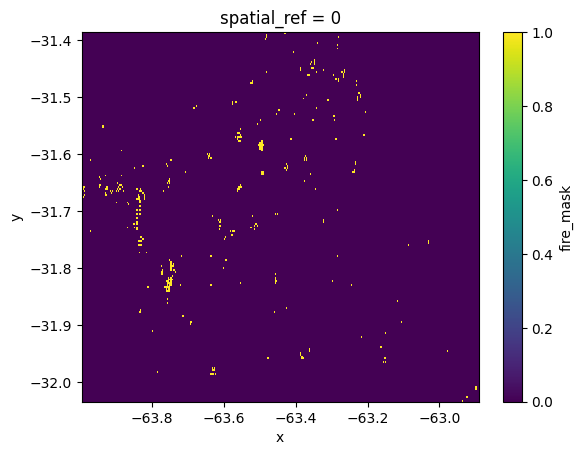

In [36]:
viirs_mask.plot()

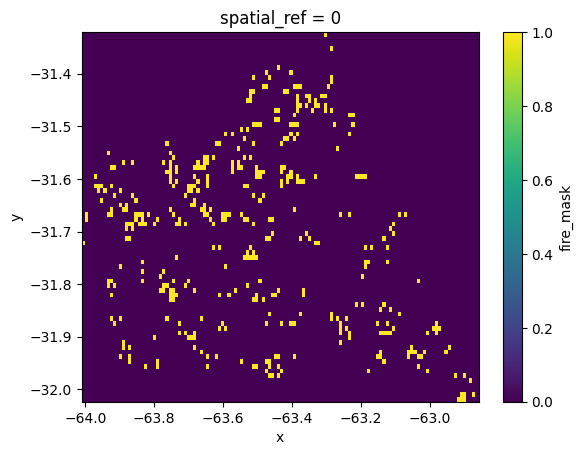

In [37]:
modis_mask.plot()

In [38]:
modis_mask.rio.to_raster("/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/modis_fire_mask_1km.tif")
viirs_mask.rio.to_raster("/home/nissim/Documents/dev/fulbright/ciut-riesgo/data/villa_del_rosario/viirs_fire_mask_375m.tif")

## Incendios

In [2]:
from typing import Any, Dict

import matplotlib.pyplot as plt
from pystac.item import Item
from shapely.geometry import shape

from pystac_client import Client

In [ ]:
URL = 'https://cmr.earthdata.nasa.gov/stac/LANCEMODIS'

catalog = Client.open(URL)  

catalog.get_collection("MYD14_6.1NRT")

In [ ]:
def intersection_percent(item: Item, aoi_geometry) -> float:
    """The percentage that the Item's geometry intersects the AOI geometry."""
    geom_item = shape(item.geometry)
    geom_aoi = aoi_geometry  # Already a geometry object
    
    intersected_geom = geom_aoi.intersection(geom_item)
    intersection_percent = (intersected_geom.area * 100) / geom_aoi.area
    
    return intersection_percent

# Extract the geometry once and reuse it
aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]

item_search = catalog.search(
    collections=["MYD14_6.1NRT"], intersects=aoi_geometry, max_items=10
)

print(
    [
        f"{intersection_percent(item, aoi_geometry):.2f}"
        for item in item_search.items()
    ]
)

In [ ]:

# Create a Client and an ItemSearch representing our search
# No search operations will be performed until we call the items() method
client = Client.open(URL)
item_search = client.search(
    collections=["MYD14_6.1NRT"], intersects=aoi, max_items=10
)

In [ ]:
from pystac_client import Client

catalog = Client.open("https://cmr.earthdata.nasa.gov/stac")

for link in catalog.links:
    print(link.href)

In [ ]:
import requests

# Search NASA's Earthdata for VIIRS collections
search_url = "https://cmr.earthdata.nasa.gov/search/collections.json"
params = {
    "keyword": "VIIRS fire",
    "page_size": 20
}

response = requests.get(search_url, params=params)
if response.status_code == 200:
    data = response.json()
    print("VIIRS collections available through Earthdata:")
    for entry in data.get("feed", {}).get("entry", []):
        print(f"  {entry.get('title')}: {entry.get('id')}")
        print(f"    Provider: {entry.get('provider')}")
        print(f"    Short name: {entry.get('short_name')}")
        print("---")

In [ ]:
from pystac_client import Client

# Try the LPCLOUD STAC endpoint directly
try:
    lpcloud_catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")
    
    print("LPCLOUD collections:")
    for link in lpcloud_catalog.links:
        if link.rel == "child":
            print(f"  {link.title}: {link.href}")
            
    # Try to access VNP14A1 collection
    vnp14a1_collection = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/VNP14A1")
    
    # Search for items
    aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]
    item_search = vnp14a1_collection.search(
        intersects=aoi_geometry,
        max_items=10
    )
    
    for item in item_search.items():
        print(f"VIIRS item: {item.id}")
        
except Exception as e:
    print(f"Error: {e}")

In [ ]:
from pystac_client import Client

# Try using the collection concept ID
collection_id = "C2545314541-LPCLOUD"

try:
    # Try different STAC endpoints
    endpoints = [
        f"https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/{collection_id}",
        f"https://cmr.earthdata.nasa.gov/stac/ALL/collections/{collection_id}",
        f"https://cmr.earthdata.nasa.gov/stac/collections/{collection_id}"
    ]
    
    for endpoint in endpoints:
        try:
            collection = Client.open(endpoint)
            print(f"Successfully opened: {endpoint}")
            print(f"Collection: {collection.title}")
            break
        except Exception as e:
            print(f"Failed {endpoint}: {e}")
            
except Exception as e:
    print(f"Error: {e}")

In [ ]:
def get_collection_info(collection_id):
    """
    Get detailed information about a VIIRS collection
    """
    url = f"https://cmr.earthdata.nasa.gov/search/collections.json"
    params = {"concept_id": collection_id}
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        collection = data['feed']['entry'][0]
        
        print(f"Collection: {collection['title']}")
        print(f"Short Name: {collection['short_name']}")
        print(f"Description: {collection['summary']}")
        print(f"Provider: {collection.get('provider', 'Unknown')}")
        print(f"Temporal Range: {collection.get('time_start')} to {collection.get('time_end')}")
        
        return collection
    else:
        print(f"Error: {response.status_code}")
        return None

# Get info about VNP14A1
get_collection_info("C2545314541-LPCLOUD")

In [ ]:
from pystac_client import Client

# Open LPDAAC catalog and search for the specific collection
lpdaac_catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPDAAC_ECS")

# Find the viirs-14a1-001 collection
viirs_link = None
for link in lpdaac_catalog.links:
    if link.rel == "child" and "VNP14A1 v001" in link.href:
        viirs_link = link
        break

if viirs_link:
    print(f"Found VIIRS collection: {viirs_link.title}")
    print(f"URL: {viirs_link.href}")
    
    # Open the collection and search for items
    viirs_collection = Client.open(viirs_link.href)
    aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]
    
    item_search = viirs_collection.search(
        intersects=aoi_geometry,
        max_items=10
    )
    
    for item in item_search.items():
        print(f"VIIRS item: {item.id}")
else:
    print("VIIRS collection not found in ALL")

In [ ]:
item_search

In [ ]:
from pystac_client import Client

# Try different potential VIIRS STAC endpoints
potential_endpoints = [
    "https://cmr.earthdata.nasa.gov/stac/LPDAAC",
    "https://cmr.earthdata.nasa.gov/stac/MODIS",
    "https://cmr.earthdata.nasa.gov/stac/VIIRS",
    "https://cmr.earthdata.nasa.gov/stac/FIRE"
]

for endpoint in potential_endpoints:
    try:
        catalog = Client.open(endpoint)
        print(f"Successfully opened: {endpoint}")
        print(f"Collections available:")
        for link in catalog.links:
            if link.rel == "child":
                print(f"  - {link.title}")
        print("---")
    except Exception as e:
        print(f"Failed to open {endpoint}: {e}")

In [ ]:
catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/USGS")

for link in catalog.links:
    print(link.href)

In [ ]:
URL = 'https://cmr.earthdata.nasa.gov/stac/LANCEMODIS'

catalog = Client.open(URL)  

catalog.get_collection("MYD14_6.1NRT")

In [4]:
import requests
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# Extract the geometry once and reuse it
aoi_geometry = aoi.to_crs(4326).geometry.iloc[0]

def setup_earthdata_auth():
    """
    Set up NASA Earthdata authentication
    You'll need to create an account at https://urs.earthdata.nasa.gov/
    """
    username = input("Enter your NASA Earthdata username: ")
    password = input("Enter your NASA Earthdata password: ")
    
    # Store credentials (you might want to use environment variables instead)
    os.environ['EARTHDATA_USERNAME'] = username
    os.environ['EARTHDATA_PASSWORD'] = password
    
    return username, password

def search_viirs_granules(collection_id, aoi_geometry, start_date, end_date, max_results=5):
    """
    Search for VIIRS granules using CMR API
    """
    cmr_url = "https://cmr.earthdata.nasa.gov/search/granules.json"
    
    bbox = aoi_geometry.bounds
    
    params = {
        "collection_concept_id": collection_id,
        "bounding_box": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
        "temporal": f"{start_date}T00:00:00Z,{end_date}T23:59:59Z",
        "page_size": max_results,
        "sort_key": "-start_date"
    }
    
    response = requests.get(cmr_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        granules = data['feed']['entry']
        
        print(f"Found {len(granules)} VIIRS granules:")
        for i, granule in enumerate(granules):
            print(f"  {i+1}. {granule['title']}")
            print(f"     Time: {granule['time_start']}")
            print(f"     Size: {granule.get('granule_size', 'Unknown')}")
            
            # Get cloud access URLs
            cloud_urls = []
            for link in granule['links']:
                if link['rel'] == 'http://esipfed.org/ns/fedsearch/1.1/data#':
                    cloud_urls.append(link['href'])
            
            if cloud_urls:
                print(f"     Cloud URL: {cloud_urls[0]}")
            print("---")
        
        return granules
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return []

# Usage
collection_id = "C2545314541-LPCLOUD"  # VNP14A1
start_date = "2023-01-01"
end_date = "2025-01-31"

granules = search_viirs_granules(collection_id, aoi_geometry, start_date, end_date)

Found 5 VIIRS granules:
  1. VNP14A1.A2025031.h12v12.002.2025032090653
     Time: 2025-01-31T00:00:00.000Z
     Size: 0.1575489044189453
     Cloud URL: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP14A1.002/VNP14A1.A2025031.h12v12.002.2025032090653/VNP14A1.A2025031.h12v12.002.2025032090653.h5
---
  2. VNP14A1.A2025030.h12v12.002.2025031094640
     Time: 2025-01-30T00:00:00.000Z
     Size: 0.15435218811035156
     Cloud URL: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP14A1.002/VNP14A1.A2025030.h12v12.002.2025031094640/VNP14A1.A2025030.h12v12.002.2025031094640.h5
---
  3. VNP14A1.A2025029.h12v12.002.2025030094347
     Time: 2025-01-29T00:00:00.000Z
     Size: 0.1571207046508789
     Cloud URL: https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/VNP14A1.002/VNP14A1.A2025029.h12v12.002.2025030094347/VNP14A1.A2025029.h12v12.002.2025030094347.h5
---
  4. VNP14A1.A2025028.h12v12.002.2025029084239
     Time: 2025-01-28T00:00:00.000Z
     Size:

In [8]:
import requests
from requests.auth import HTTPBasicAuth
import h5py
import matplotlib.pyplot as plt

# Download the file
username = "nissimlebovits"
password = "KNsna3qk6aPEEvk"

print("Downloading VIIRS file...")
response = requests.get(cloud_url, auth=HTTPBasicAuth(username, password))

if response.status_code == 200:
    with open("temp_viirs.h5", "wb") as f:
        f.write(response.content)
    
    # Open with h5py
    with h5py.File("temp_viirs.h5", "r") as f:
        fire_mask = f['HDFEOS/GRIDS/VNP_Grid_1km_2D/Data Fields/FireMask'][:]
        
    plt.imshow(fire_mask)
    plt.title('VIIRS Fire Mask')
    plt.show()
    
    # Clean up
    import os
    os.remove("temp_viirs.h5")
else:
    print(f"Download failed: {response.status_code}")

Download failed: 401


In [7]:
import earthaccess

auth = earthaccess.login()

In [ ]:
import earthaccess

# Extract individual bounding box values
bbox = aoi.to_crs(4326).bounds.iloc[0]
minx, miny, maxx, maxy = bbox

# Search for VIIRS data
viirs_data = earthaccess.search_data(
    short_name="VNP14A1",
    bounding_box=(minx, miny, maxx, maxy),  # Pass as tuple
    cloud_hosted=True,
    temporal=("2001-01", "2021-01"),
)

print(f"Found {len(viirs_data)} granules")

# First, get the coordinate system and find exact pixel bounds for your AOI
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_path = files[0]

with h5py.File(file_path, 'r') as f:
    xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
    ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

# Transform AOI to sinusoidal projection
aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
aoi_bounds = aoi_sinusoidal.bounds.iloc[0]

# Find exact pixel indices for your AOI
x_indices = np.where((xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2]))[0]
y_indices = np.where((ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3]))[0]

print(f"Cropping to {len(y_indices)} x {len(x_indices)} pixels instead of full {len(ydim)} x {len(xdim)}")

Found 3300 granules


File size range: 0.000 - 0.000 MB
Average file size: 0.000 MB


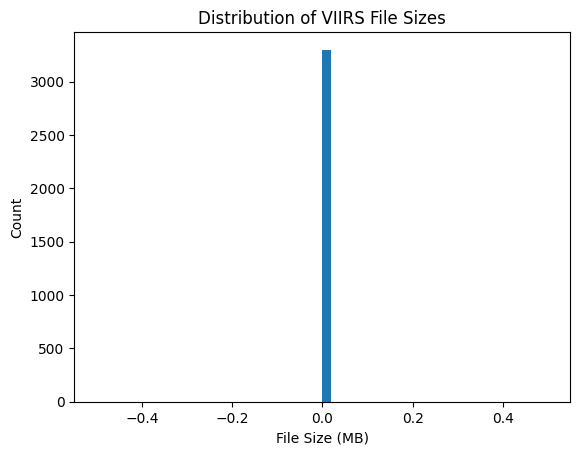

Manually checking first 5 files...

File 1:
Size: 0.000 MB
FireMask shape: (1200, 1200)
FireMask unique values: [3 4 5 6 7 8 9]
Fire pixels (>=7): 31
AOI fire pixels: 0

File 2:
Size: 0.000 MB
FireMask shape: (1200, 1200)
FireMask unique values: [3 4 5 6 8 9]
Fire pixels (>=7): 8
AOI fire pixels: 0

File 3:
Size: 0.000 MB
FireMask shape: (1200, 1200)
FireMask unique values: [3 4 5 8 9]
Fire pixels (>=7): 7
AOI fire pixels: 0

File 4:
Size: 0.000 MB
FireMask shape: (1200, 1200)
FireMask unique values: [3 4 5 8 9]
Fire pixels (>=7): 8
AOI fire pixels: 0

File 5:
Size: 0.000 MB
FireMask shape: (1200, 1200)
FireMask unique values: [3 4 5 8 9]
Fire pixels (>=7): 21
AOI fire pixels: 0


In [25]:
# Let's check what file sizes we actually have
file_sizes = [granule.get('Size(MB)', 0) for granule in viirs_data]
print(f"File size range: {min(file_sizes):.3f} - {max(file_sizes):.3f} MB")
print(f"Average file size: {np.mean(file_sizes):.3f} MB")

# Check the distribution
import matplotlib.pyplot as plt
plt.hist(file_sizes, bins=50)
plt.xlabel('File Size (MB)')
plt.ylabel('Count')
plt.title('Distribution of VIIRS File Sizes')
plt.show()

# Let's actually check a few files manually to see what's in them
print("Manually checking first 5 files...")
for i, granule in enumerate(viirs_data[:5]):
    print(f"\nFile {i+1}:")
    print(f"Size: {granule.get('Size(MB)', 0):.3f} MB")
    
    try:
        files = earthaccess.open([granule], show_progress=False)
        file_path = files[0]
        
        with h5py.File(file_path, 'r') as f:
            fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][:]
            print(f"FireMask shape: {fire_mask.shape}")
            print(f"FireMask unique values: {np.unique(fire_mask)}")
            print(f"Fire pixels (>=7): {np.sum(fire_mask >= 7)}")
            
            # Check if our AOI area has any fire
            if len(y_indices) > 0 and len(x_indices) > 0:
                aoi_fire_mask = fire_mask[y_indices, :][:, x_indices]
                print(f"AOI fire pixels: {np.sum(aoi_fire_mask >= 7)}")
                
    except Exception as e:
        print(f"Error: {e}")

In [27]:
# Process in batches to avoid memory issues
batch_size = 100
fire_counts = []

for i in range(0, len(viirs_data), batch_size):
    batch = viirs_data[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(viirs_data)-1)//batch_size + 1}")
    
    # Your existing efficient processing
    lazy_arrays = [process_granule_cropped(granule) for granule in batch]
    fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(len(y_indices), len(x_indices))) 
                          for arr in lazy_arrays if arr is not None])
    fire_count_batch = da.sum(fire_stack, axis=0)
    
    with ProgressBar():
        fire_counts.append(fire_count_batch.compute())

# Sum all batches
final_fire_count = np.sum(fire_counts, axis=0)

Processing batch 1/33
[########################################] | 100% Completed | 190.47 s
Processing batch 2/33
[                                        ] | 0% Completed | 8.79 s ms


KeyboardInterrupt: 

In [26]:
# Let's check what's happening with the AOI cropping
print("AOI Debugging:")
print(f"AOI bounds (sinusoidal): {aoi_bounds}")
print(f"X indices range: {x_indices.min()} to {x_indices.max()}")
print(f"Y indices range: {y_indices.min()} to {y_indices.max()}")
print(f"AOI size: {len(y_indices)} x {len(x_indices)} pixels")

# Let's see where the fires actually are
print("\nChecking fire locations in first file...")
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_path = files[0]

with h5py.File(file_path, 'r') as f:
    fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][:]
    xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
    ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]
    
    # Find where the fires are
    fire_locations = np.where(fire_mask >= 7)
    print(f"Fire locations (y, x): {list(zip(fire_locations[0][:5], fire_locations[1][:5]))}")
    
    # Check the coordinates of fire pixels
    for i in range(min(5, len(fire_locations[0]))):
        y_idx, x_idx = fire_locations[0][i], fire_locations[1][i]
        fire_x = xdim[x_idx]
        fire_y = ydim[y_idx]
        print(f"Fire {i+1}: pixel ({y_idx}, {x_idx}) -> coords ({fire_x:.0f}, {fire_y:.0f})")
    
    print(f"\nAOI coordinate bounds:")
    print(f"X: {xdim[x_indices].min():.0f} to {xdim[x_indices].max():.0f}")
    print(f"Y: {ydim[y_indices].min():.0f} to {ydim[y_indices].max():.0f}")

AOI Debugging:
AOI bounds (sinusoidal): minx   -6.073920e+06
miny   -3.548564e+06
maxx   -5.935100e+06
maxy   -3.465906e+06
Name: 126, dtype: float64
X indices range: 646 to 794
Y indices range: 141 to 229
AOI size: 89 x 149 pixels

Checking fire locations in first file...
Fire locations (y, x): [(np.int64(8), np.int64(672)), (np.int64(32), np.int64(1046)), (np.int64(33), np.int64(1046)), (np.int64(56), np.int64(1011)), (np.int64(57), np.int64(1010))]
Fire 1: pixel (8, 672) -> coords (-6049011, -3343265)
Fire 2: pixel (32, 1046) -> coords (-5702453, -3365504)
Fire 3: pixel (33, 1046) -> coords (-5702453, -3366430)
Fire 4: pixel (56, 1011) -> coords (-5734885, -3387743)
Fire 5: pixel (57, 1010) -> coords (-5735811, -3388669)

AOI coordinate bounds:
X: -6073103 to -5935963
Y: -3548049 to -3466506


In [24]:
# Option 1: Use file size as a proxy (fire-active files are usually larger)
def quick_fire_check_by_size(granules):
    """Use file size as a proxy for fire activity - much faster"""
    fire_active = []
    
    for granule in granules:
        # Get file size from granule metadata
        size_mb = granule.get('Size(MB)', 0)
        
        # VIIRS files with fire data are typically > 1MB
        # Files < 0.5MB are usually empty/no-fire days
        if size_mb > 0.5:  # Adjust threshold as needed
            fire_active.append(granule)
    
    return fire_active

# Option 2: Sample approach - check every 10th file first
def sample_check(granules, sample_rate=10):
    """Check a sample of files to estimate fire activity"""
    sample_granules = granules[::sample_rate]  # Every 10th file
    
    fire_count = 0
    for granule in sample_granules:
        try:
            files = earthaccess.open([granule], show_progress=False)
            file_path = files[0]
            
            with h5py.File(file_path, 'r') as f:
                fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][y_indices, :][:, x_indices]
                if np.any(fire_mask >= 7):
                    fire_count += 1
        except:
            pass
    
    fire_rate = fire_count / len(sample_granules)
    print(f"Estimated fire activity rate: {fire_rate:.2%}")
    
    return fire_rate

# Try the fast approach first
print("Quick check by file size...")
fire_active_by_size = quick_fire_check_by_size(viirs_data)
print(f"Found {len(fire_active_by_size)} potentially fire-active files")

# Sample check to validate
print("Sampling to validate...")
fire_rate = sample_check(viirs_data[:100])  # Check first 100 files

Quick check by file size...
Found 0 potentially fire-active files
Sampling to validate...
Estimated fire activity rate: 0.00%


In [21]:
import earthaccess
import h5py
import numpy as np
import dask.array as da
from dask.delayed import delayed
from dask.diagnostics import ProgressBar

# 1. Check current cache settings
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_handler = files[0]
print("Current cache settings:")
print(file_handler.f.cache)

# 2. Try optimized cache settings for HDF5
# Based on docs: align block size with HDF5 chunk size
optimized_open_kwargs = {
    'block_size': 16 * 1024 * 1024,  # 16MB blocks (for large files)
    'cache_type': 'blockcache'  # Use blockcache instead of readahead
}

files_optimized = earthaccess.open([viirs_data[0]], 
                                 open_kwargs=optimized_open_kwargs, 
                                 show_progress=False)
file_handler_opt = files_optimized[0]
print("\nOptimized cache settings:")
print(file_handler_opt.f.cache)

# 3. Test different batch sizes
def test_batch_performance(batch_size):
    print(f"\nTesting batch size: {batch_size}")
    
    @delayed
    def process_batch(granules_batch):
        results = []
        files = earthaccess.open(granules_batch, 
                               open_kwargs=optimized_open_kwargs,
                               show_progress=False)
        
        for file_path in files:
            try:
                with h5py.File(file_path, 'r') as f:
                    fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][y_indices, :][:, x_indices]
                    results.append((fire_mask >= 7).astype(np.int8))
            except Exception as e:
                print(f"Error: {e}")
                results.append(None)
        
        return results
    
    # Test with first batch_size granules
    test_granules = viirs_data[:batch_size]
    batch_results = process_batch(test_granules)
    
    return batch_results

# 4. Test different batch sizes
batch_sizes = [1, 5, 10, 20]
for batch_size in batch_sizes:
    if batch_size <= len(viirs_data):
        result = test_batch_performance(batch_size)
        print(f"Batch size {batch_size}: {result}")

# 5. Check if files are cloud-optimized
def check_file_optimization(file_handler):
    print(f"\nFile optimization check:")
    cache = file_handler.f.cache
    
    # Different cache types have different attributes
    if hasattr(cache, 'block_size'):
        print(f"Block size: {cache.block_size}")
    elif hasattr(cache, 'blocksize'):
        print(f"Block size: {cache.blocksize}")
    else:
        print(f"Block size: Not available")
    
    print(f"Cache type: {type(cache).__name__}")
    print(f"Cache info: {cache}")
    
    # Test metadata access speed
    import time
    start = time.time()
    with h5py.File(file_handler, 'r') as f:
        # Try to access metadata
        attrs = f.attrs
        groups = list(f.keys())
    end = time.time()
    print(f"Metadata access time: {end - start:.2f} seconds")
    
    return end - start

# Check optimization
metadata_time = check_file_optimization(file_handler_opt)

# 6. Try different cache configurations
cache_configs = [
    {'block_size': 4 * 1024 * 1024, 'cache_type': 'blockcache'},   # 4MB
    {'block_size': 8 * 1024 * 1024, 'cache_type': 'blockcache'},   # 8MB  
    {'block_size': 16 * 1024 * 1024, 'cache_type': 'blockcache'},  # 16MB
    {'block_size': 32 * 1024 * 1024, 'cache_type': 'blockcache'}, # 32MB
]

print("\nTesting different cache configurations:")
for i, config in enumerate(cache_configs):
    print(f"\nConfig {i+1}: {config}")
    files_test = earthaccess.open([viirs_data[0]], 
                                open_kwargs=config, 
                                show_progress=False)
    file_test = files_test[0]
    print(f"Cache: {file_test.f.cache}")

Current cache settings:

        <BackgroundBlockCache:
            block size  :   4194304
            block count :   1
            file size   :   204116
            cache hits  :   0
            cache misses:   0
            total requested bytes: 0>
        

Optimized cache settings:

        <BlockCache:
            block size  :   16777216
            block count :   1
            file size   :   204116
            cache hits  :   0
            cache misses:   0
            total requested bytes: 0>
        

Testing batch size: 1
Batch size 1: Delayed('process_batch-944d1982-97be-473a-8055-ca50ff35193a')

Testing batch size: 5
Batch size 5: Delayed('process_batch-486d1c97-a42c-442e-b9a9-ebe8ceadfc67')

Testing batch size: 10
Batch size 10: Delayed('process_batch-f811d9f5-7739-4d39-a332-48dbd4b8184f')

Testing batch size: 20
Batch size 20: Delayed('process_batch-2a8351b4-f03e-435d-9392-1f101bc4375a')

File optimization check:
Block size: 16777216
Cache type: BlockCache
Cache in

In [ ]:
import earthaccess
import h5py
import numpy as np
import dask.array as da
from dask.delayed import delayed
from dask.diagnostics import ProgressBar

# Extract individual bounding box values
bbox = aoi.to_crs(4326).bounds.iloc[0]
minx, miny, maxx, maxy = bbox

# Search for VIIRS data
viirs_data = earthaccess.search_data(
    short_name="VNP14A1",
    bounding_box=(minx, miny, maxx, maxy),
    cloud_hosted=True,
    temporal=("2020-01", "2021-01"),
)

print(f"Found {len(viirs_data)} granules")

# Get coordinate system and find exact pixel bounds
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_path = files[0]

with h5py.File(file_path, 'r') as f:
    xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
    ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

# Transform AOI to sinusoidal projection
aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
aoi_bounds = aoi_sinusoidal.bounds.iloc[0]

# Find exact pixel indices for your AOI
x_indices = np.where((xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2]))[0]
y_indices = np.where((ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3]))[0]

print(f"Cropping to {len(y_indices)} x {len(x_indices)} pixels instead of full {len(ydim)} x {len(xdim)}")

# Efficient lazy function that only loads the cropped area
@delayed
def process_granule_cropped(granule):
    try:
        files = earthaccess.open([granule], show_progress=False)
        file_path = files[0]
        
        with h5py.File(file_path, 'r') as f:
            # Use advanced indexing to load only the pixels we need
            fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][y_indices, :][:, x_indices]
            return (fire_mask >= 7).astype(np.int8)
    except Exception as e:
        print(f"Error processing granule: {e}")
        return None

# Create lazy arrays for cropped data only
print(f"Creating lazy arrays for {len(viirs_data)} granules...")
lazy_arrays = [process_granule_cropped(granule) for granule in viirs_data]

# Stack into dask array with correct cropped dimensions
fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(len(y_indices), len(x_indices))) 
                      for arr in lazy_arrays if arr is not None])

# Sum across time dimension
fire_count_map = da.sum(fire_stack, axis=0)

# Compute with progress bar
print("Computing fire count map...")
with ProgressBar():
    fire_count_result = fire_count_map.compute()  # Fixed: was fire_count_result.compute()

# Plot directly (no need to crop again)
plt.figure(figsize=(12, 8))
im = plt.imshow(fire_count_result, cmap='Reds', 
               extent=[xdim[x_indices].min(), xdim[x_indices].max(), 
                      ydim[y_indices].min(), ydim[y_indices].max()])

aoi_sinusoidal.boundary.plot(ax=plt.gca(), color='black', linewidth=2)
plt.title(f'Fire Observation Count ({len(viirs_data)} days)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

cbar = plt.colorbar(im)
cbar.set_label('Number of Fire Observations')
plt.show()

print(f"Maximum fire observations: {fire_count_result.max()}")

In [19]:
import earthaccess
import h5py
import numpy as np
import dask.array as da
from dask.delayed import delayed
from dask.diagnostics import ProgressBar

# Extract individual bounding box values
bbox = aoi.to_crs(4326).bounds.iloc[0]
minx, miny, maxx, maxy = bbox

# Search for VIIRS data
viirs_data = earthaccess.search_data(
    short_name="VNP14A1",
    bounding_box=(minx, miny, maxx, maxy),
    cloud_hosted=True,
    temporal=("2001-01", "2021-01"),
)

print(f"Found {len(viirs_data)} granules")

# Get coordinate system and find exact pixel bounds
files = earthaccess.open([viirs_data[0]], show_progress=False)
file_path = files[0]

with h5py.File(file_path, 'r') as f:
    xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
    ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

# Transform AOI to sinusoidal projection
aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
aoi_bounds = aoi_sinusoidal.bounds.iloc[0]

# Find exact pixel indices for your AOI
x_indices = np.where((xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2]))[0]
y_indices = np.where((ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3]))[0]

print(f"Cropping to {len(y_indices)} x {len(x_indices)} pixels instead of full {len(ydim)} x {len(xdim)}")

# Efficient lazy function that only loads the cropped area
@delayed
def process_granule_cropped(granule):
    try:
        files = earthaccess.open([granule], show_progress=False)
        file_path = files[0]
        
        with h5py.File(file_path, 'r') as f:
            # Use advanced indexing to load only the pixels we need
            fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][y_indices, :][:, x_indices]
            return (fire_mask >= 7).astype(np.int8)
    except Exception as e:
        print(f"Error processing granule: {e}")
        return None

# Create lazy arrays for cropped data only
print(f"Creating lazy arrays for {len(viirs_data)} granules...")
lazy_arrays = [process_granule_cropped(granule) for granule in viirs_data]

# Stack into dask array with correct cropped dimensions
fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(len(y_indices), len(x_indices))) 
                      for arr in lazy_arrays if arr is not None])

# Sum across time dimension
fire_count_map = da.sum(fire_stack, axis=0)

# Compute with progress bar
print("Computing fire count map...")
with ProgressBar():
    fire_count_result = fire_count_map.compute()  # Fixed: was fire_count_result.compute()

# Plot directly (no need to crop again)
plt.figure(figsize=(12, 8))
im = plt.imshow(fire_count_result, cmap='Reds', 
               extent=[xdim[x_indices].min(), xdim[x_indices].max(), 
                      ydim[y_indices].min(), ydim[y_indices].max()])

aoi_sinusoidal.boundary.plot(ax=plt.gca(), color='black', linewidth=2)
plt.title(f'Fire Observation Count ({len(viirs_data)} days)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

cbar = plt.colorbar(im)
cbar.set_label('Number of Fire Observations')
plt.show()

print(f"Maximum fire observations: {fire_count_result.max()}")

Found 3300 granules
Cropping to 89 x 149 pixels instead of full 1200 x 1200
Creating lazy arrays for 3300 granules...
Computing fire count map...
[##                                      ] | 7% Completed | 447.47 ss


KeyboardInterrupt: 

Creating lazy arrays for 59 granules...
Stacking lazy arrays...
Computing fire count map (lazy)...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Computing final result...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

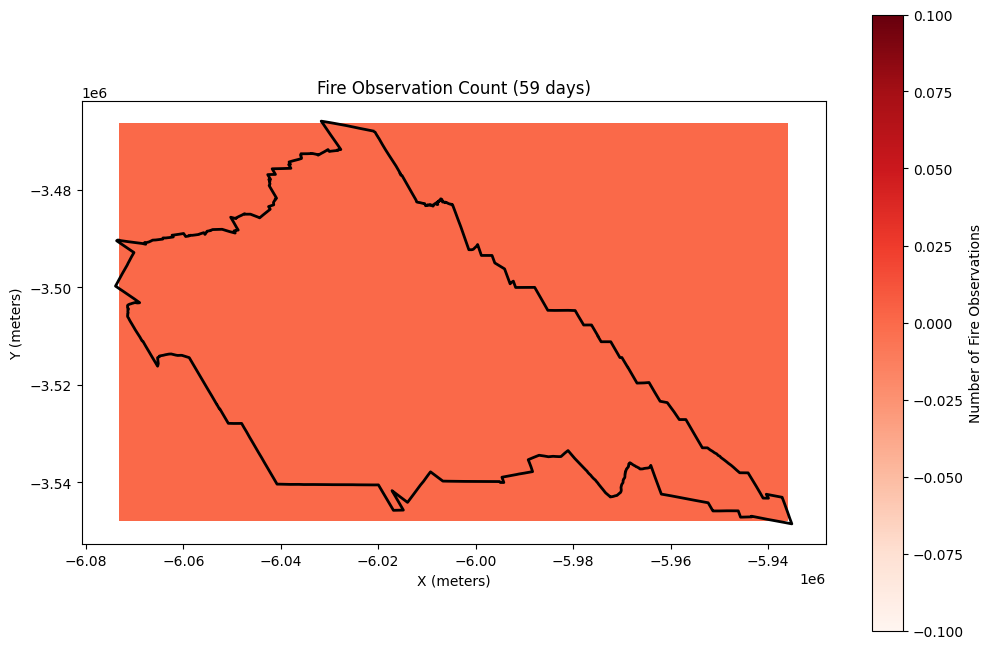

Maximum fire observations: 0


In [10]:
import dask.array as da
import h5py
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from dask.delayed import delayed
import warnings

# Use context manager to ensure no progress bars
from dask.diagnostics import ProgressBar
import dask

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)


@delayed
def process_granule_lazy(granule):
    """Lazy processing of a single granule"""
    try:
        files = earthaccess.open([granule])
        file_path = files[0]
        
        with h5py.File(file_path, 'r') as f:
            fire_mask = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/Data Fields/FireMask'][:]
            return (fire_mask >= 7).astype(np.int8)
    except Exception as e:
        print(f"Error processing granule: {e}")
        return None

# Create lazy arrays for all granules
print(f"Creating lazy arrays for {len(viirs_data)} granules...")
lazy_arrays = [process_granule_lazy(granule) for granule in viirs_data]

# Stack into a single dask array (lazy - no computation yet)
print("Stacking lazy arrays...")
fire_stack = da.stack([da.from_delayed(arr, dtype=np.int8, shape=(1200, 1200)) 
                      for arr in lazy_arrays if arr is not None])

# Sum across time dimension (still lazy!)
print("Computing fire count map (lazy)...")
fire_count_map = da.sum(fire_stack, axis=0)

# Get coordinate info from first granule
files = earthaccess.open([viirs_data[0]])
file_path = files[0]
with h5py.File(file_path, 'r') as f:
    xdim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/XDim'][:]
    ydim = f['HDFEOS/GRIDS/VIIRS_Grid_Daily_Fire/YDim'][:]

# Transform AOI and crop
aoi_sinusoidal = aoi.to_crs("EPSG:4326").to_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
aoi_bounds = aoi_sinusoidal.bounds.iloc[0]
x_mask = (xdim >= aoi_bounds.iloc[0]) & (xdim <= aoi_bounds.iloc[2])
y_mask = (ydim >= aoi_bounds.iloc[1]) & (ydim <= aoi_bounds.iloc[3])

# Crop the lazy array
fire_count_cropped = fire_count_map[y_mask][:, x_mask]

# Now compute the result with NO progress bars
print("Computing final result...")



# Temporarily disable all callbacks
original_callbacks = dask.callbacks.Callback.active.copy()
dask.callbacks.Callback.active.clear()

try:
    fire_count_result = fire_count_cropped.compute()
finally:
    # Restore original callbacks
    dask.callbacks.Callback.active.update(original_callbacks)

# Plot
plt.figure(figsize=(12, 8))
im = plt.imshow(fire_count_result, cmap='Reds', 
               extent=[xdim[x_mask].min(), xdim[x_mask].max(), 
                      ydim[y_mask].min(), ydim[y_mask].max()])

aoi_sinusoidal.boundary.plot(ax=plt.gca(), color='black', linewidth=2)
plt.title(f'Fire Observation Count ({len(viirs_data)} days)')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

cbar = plt.colorbar(im)
cbar.set_label('Number of Fire Observations')
plt.show()

print(f"Maximum fire observations: {fire_count_result.max()}")

## Cobertura del suelo

In [ ]:
import rioxarray as rio

# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 1024, "y": 1024},
)

# Clip with from_disk=True for memory efficiency
suelo_2022 = suelo_2022.rio.clip(
    aoi.geometry.values,
    aoi.crs,
    from_disk=True,
)

In [ ]:
# Define the detailed categories and colors
categories_detailed = {
    'Leñosa cerrada': {'ids': [3], 'color': '#1f8d49'},
    'Leñosa abierta': {'ids': [4], 'color': '#7dc975'},
    'Leñosa dispersa': {'ids': [45], 'color': '#807a40'},
    'Leñosa inundable': {'ids': [6], 'color': '#026975'},
    'Vegetación no leñosa inundable': {'ids': [11], 'color': '#519799'},
    'Pastizal': {'ids': [12], 'color': '#d6bc74'},
    'Estepa': {'ids': [63], 'color': '#ebf8b5'},
    'Pastura': {'ids': [15], 'color': '#edde8e'},
    'Agricultura': {'ids': [18], 'color': '#e974ed'},
    'Plantación forestal': {'ids': [9], 'color': '#7a5900'},
    'Cultivo arbustivo': {'ids': [36], 'color': '#d082de'},
    'Mosaico agropecuario': {'ids': [21], 'color': '#ffefc3'},
    'Área sin vegetación': {'ids': [22], 'color': '#d4271e'},
    'Río, lago u océano': {'ids': [33], 'color': '#2532e4'},
    'Hielo y nieve en superficie': {'ids': [34], 'color': '#93dfe6'},
    'No observado': {'ids': [27], 'color': '#ffffff'}
}

# You can also create grouped categories for broader analysis
categories_grouped = {
    'Vegetación leñosa': {
        'ids': [3, 4, 45, 6], 
        'color': '#1f8d49',
        'subcategories': ['Leñosa cerrada', 'Leñosa abierta', 'Leñosa dispersa', 'Leñosa inundable']
    },
    'Vegetación no leñosa': {
        'ids': [11, 12, 63], 
        'color': '#d6bc74',
        'subcategories': ['Vegetación no leñosa inundable', 'Pastizal', 'Estepa']
    },
    'Área agropecuaria': {
        'ids': [15, 18, 9, 36, 21], 
        'color': '#ffefc3',
        'subcategories': ['Pastura', 'Agricultura', 'Plantación forestal', 'Cultivo arbustivo', 'Mosaico agropecuario']
    },
    'Área sin vegetación': {
        'ids': [22], 
        'color': '#d4271e',
        'subcategories': ['Área sin vegetación']
    },
    'Cuerpo de agua': {
        'ids': [33, 34], 
        'color': '#2532e3',
        'subcategories': ['Río, lago u océano', 'Hielo y nieve en superficie']
    },
    'No observado': {
        'ids': [27], 
        'color': '#ffffff',
        'subcategories': ['No observado']
    }
}

# Function to categorize pixels
def categorize_pixel_detailed(value, categories):
    """Convert pixel value to detailed category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        colors[pixel_id] = info['color']

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2022.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info['color']] = category

# Add legend below the map
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=label) 
                  for color, label in legend_labels.items()]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
          ncol=3, frameon=False)

plt.title('Cobertura del Suelo - MapBiomas 2022')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Calculate pixel counts for each category
unique_values, counts = np.unique(suelo_2022.values[0], return_counts=True)

# Create a mapping from pixel IDs to category names
id_to_category = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        id_to_category[pixel_id] = category

# Calculate total pixels and area per pixel (assuming 100m resolution)
total_pixels = np.sum(counts)
pixel_area_hectares = 0.01  # 100m x 100m = 1 hectare

# Create results list
results = []
for pixel_id, count in zip(unique_values, counts):
    if pixel_id in id_to_category:
        category = id_to_category[pixel_id]
        area_hectares = count * pixel_area_hectares
        percentage = (count / total_pixels) * 100
        results.append({
            'Categoría': category,
            'ID': pixel_id,
            'Área (hectáreas)': f"{area_hectares:,.1f}",
            'Porcentaje (%)': f"{percentage:.1f}"
        })

# Sort by area (descending)
results.sort(key=lambda x: float(x['Área (hectáreas)'].replace(',', '')), reverse=True)

# Create DataFrame and display
df = pd.DataFrame(results)
print("Cobertura del Suelo - MapBiomas 2022")
print("=" * 50)
print(df.to_string(index=False))
print(f"\nTotal área: {total_pixels * pixel_area_hectares:,.1f} hectáreas")

In [ ]:
import rioxarray as rio

# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2000_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2000.tif"

suelo_2000 = rio.open_rasterio(
    suelo_2000_ruta,
    chunks={"x": 1024, "y": 1024},
)

# Clip with from_disk=True for memory efficiency
suelo_2000 = suelo_2000.rio.clip(
    aoi.geometry.values,
    aoi.crs,
    from_disk=True,
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        colors[pixel_id] = info['color']

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2000.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info['color']] = category

# Add legend below the map
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=label) 
                  for color, label in legend_labels.items()]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
          ncol=3, frameon=False)

plt.title('Cobertura del Suelo - MapBiomas 2000')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Calculate pixel counts for each category
unique_values, counts = np.unique(suelo_2000.values[0], return_counts=True)

# Create a mapping from pixel IDs to category names
id_to_category = {}
for category, info in categories_detailed.items():
    for pixel_id in info['ids']:
        id_to_category[pixel_id] = category

# Calculate total pixels and area per pixel (assuming 100m resolution)
total_pixels = np.sum(counts)
pixel_area_hectares = 0.01  # 100m x 100m = 1 hectare

# Create results list
results = []
for pixel_id, count in zip(unique_values, counts):
    if pixel_id in id_to_category:
        category = id_to_category[pixel_id]
        area_hectares = count * pixel_area_hectares
        percentage = (count / total_pixels) * 100
        results.append({
            'Categoría': category,
            'ID': pixel_id,
            'Área (hectáreas)': f"{area_hectares:,.1f}",
            'Porcentaje (%)': f"{percentage:.1f}"
        })

# Sort by area (descending)
results.sort(key=lambda x: float(x['Área (hectáreas)'].replace(',', '')), reverse=True)

# Create DataFrame and display
df = pd.DataFrame(results)
print("Cobertura del Suelo - MapBiomas 2000")
print("=" * 50)
print(df.to_string(index=False))
print(f"\nTotal área: {total_pixels * pixel_area_hectares:,.1f} hectáreas")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

# Get the raw pixel values
suelo_2000_values = suelo_2000.values[0]
suelo_2022_values = suelo_2022.values[0]

# Convert to grouped categories
suelo_2000_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2000_values)
suelo_2022_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2022_values)

# Create transition map
transition_map = np.zeros_like(suelo_2000_cat, dtype=int)

# Only process pixels that actually changed
changed_mask = (suelo_2000_values != suelo_2022_values)

# Transition 1: Agriculture/non-vegetated → Forest/natural (natural regrowth)
mask1 = changed_mask & ((suelo_2000_cat == 'Área agropecuaria') | 
                       (suelo_2000_cat == 'Área sin vegetación')) & \
        ((suelo_2022_cat == 'Vegetación leñosa') | 
         (suelo_2022_cat == 'Vegetación no leñosa'))
transition_map[mask1] = 1

# Transition 2: Forest/natural → Agriculture/non-vegetated
mask2 = changed_mask & ((suelo_2000_cat == 'Vegetación leñosa') | 
                       (suelo_2000_cat == 'Vegetación no leñosa')) & \
        ((suelo_2022_cat == 'Área agropecuaria') | 
         (suelo_2022_cat == 'Área sin vegetación'))
transition_map[mask2] = 2

# Transition 3: Water gain
mask3 = changed_mask & (suelo_2000_cat != 'Cuerpo de agua') & (suelo_2022_cat == 'Cuerpo de agua')
transition_map[mask3] = 3

# Transition 4: Water loss
mask4 = changed_mask & (suelo_2000_cat == 'Cuerpo de agua') & (suelo_2022_cat != 'Cuerpo de agua')
transition_map[mask4] = 4

# Transition 5: Forest plantation gain (only specific plantation types)
mask5 = changed_mask & (suelo_2000_cat == 'Área agropecuaria') & (suelo_2022_cat == 'Vegetación leñosa') & (suelo_2022_values == 9)
transition_map[mask5] = 5

# Transition 6: Other changes (catch-all for remaining changed pixels)
mask6 = changed_mask & (transition_map == 0)
transition_map[mask6] = 6

# Transition 7: No change
transition_map[~changed_mask] = 7

# Colors
colors = {
    0: '#cccccc',  # Unclassified
    1: '#06ff00',  # Agriculture → Forest/natural (regeneration)
    2: '#ff0000',  # Forest/natural → Agriculture
    3: '#0066cc',  # Water gain
    4: '#ff6600',  # Water loss
    5: '#8a2be2',  # Forest plantation gain
    6: '#ffa500',  # Other changes
    7: '#aaa9a9'   # No change
}

labels = {
    0: 'No clasificado',
    1: 'Agricultura → Forestal/natural',
    2: 'Forestal/natural → Agricultura',
    3: 'Ganancia de agua',
    4: 'Pérdida de agua',
    5: 'Ganancia plantación forestal',
    6: 'Otros cambios',
    7: 'Sin cambio'
}

# Create colormap
cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(transition_map, cmap=cmap, norm=norm)

# Legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors[i], label=labels[i]) 
                  for i in sorted(colors.keys())]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), 
          ncol=2, frameon=False)

plt.title('Transiciones de Cobertura del Suelo (2000-2022)')
plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

def categorize_pixel_grouped(value, categories):
    """Convert pixel value to grouped category name"""
    for category, info in categories.items():
        if value in info['ids']:
            return category
    return 'Other'

# Convert pixel values to grouped categories
suelo_2000_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2000.values[0])
suelo_2022_cat = np.vectorize(lambda x: categorize_pixel_grouped(x, categories_grouped))(suelo_2022.values[0])

# Calculate pixel counts for each category
unique_2000, counts_2000 = np.unique(suelo_2000_cat, return_counts=True)
unique_2022, counts_2022 = np.unique(suelo_2022_cat, return_counts=True)

# Filter out 'Other' and get only categories that exist
existing_2000 = unique_2000[unique_2000 != 'Other']
existing_2022 = unique_2022[unique_2022 != 'Other']

# Calculate total pixels
total_2000 = sum(counts_2000[unique_2000 != 'Other'])
total_2022 = sum(counts_2022[unique_2022 != 'Other'])

# Create transition matrix
transition_matrix = {}
for cat_2000 in existing_2000:
    transition_matrix[cat_2000] = {}
    mask_2000 = (suelo_2000_cat == cat_2000)
    for cat_2022 in existing_2022:
        mask_2022 = (suelo_2022_cat == cat_2022)
        transition_count = np.sum(mask_2000 & mask_2022)
        if transition_count > 0:
            transition_matrix[cat_2000][cat_2022] = transition_count

# Prepare data for Sankey diagram
source = []
target = []
value = []
node_labels = []
node_colors = []

# Add 2000 categories
for cat in existing_2000:
    count = counts_2000[unique_2000 == cat][0]
    percentage = (count / total_2000) * 100
    node_labels.append(f"{cat}<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]['color'])

# Add 2022 categories
for cat in existing_2022:
    count = counts_2022[unique_2022 == cat][0]
    percentage = (count / total_2022) * 100
    node_labels.append(f"{cat}<br>({percentage:.1f}%)")
    node_colors.append(categories_grouped[cat]['color'])

# Create links
link_colors = []
for cat_2000, transitions in transition_matrix.items():
    for cat_2022, count in transitions.items():
        source_idx = node_labels.index(f"{cat_2000}<br>({(counts_2000[unique_2000 == cat_2000][0] / total_2000) * 100:.1f}%)")
        target_idx = node_labels.index(f"{cat_2022}<br>({(counts_2022[unique_2022 == cat_2022][0] / total_2022) * 100:.1f}%)")
        
        source.append(source_idx)
        target.append(target_idx)
        value.append(count)
        link_colors.append(categories_grouped[cat_2000]['color'])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors
    )
)])

fig.update_layout(
    title_text="Transiciones de Cobertura del Suelo (2000-2022)",
    font_size=12,
    width=1000,
    height=600
)

fig.show()